In [1]:
!pip install tensorflow==2.15
import os
import tensorflow as tf
import pandas as pd
import numpy as np
from google.colab import drive
import matplotlib
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.layers import TextVectorization
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

In [3]:
drive.mount('/content/drive')
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,""":::::And for the second time of asking, when ...",0,0,0,0,0,0
159567,ffea4adeee384e90,You should be ashamed of yourself \n\nThat is ...,0,0,0,0,0,0
159568,ffee36eab5c267c9,"Spitzer \n\nUmm, theres no actual article for ...",0,0,0,0,0,0
159569,fff125370e4aaaf3,And it looks like it was actually you who put ...,0,0,0,0,0,0
159570,fff46fc426af1f9a,"""\nAnd ... I really don't think you understand...",0,0,0,0,0,0


In [5]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
import re
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

df['comment_text'] = df['comment_text'].apply(preprocess_text)

In [7]:
df.tail()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
159566,ffe987279560d7ff,second time asking view completely contradicts...,0,0,0,0,0,0
159567,ffea4adeee384e90,ashamed horrible thing put talk page,0,0,0,0,0,0
159568,ffee36eab5c267c9,spitzer umm theres actual article prostitution...,0,0,0,0,0,0
159569,fff125370e4aaaf3,looks like actually put speedy first version d...,0,0,0,0,0,0
159570,fff46fc426af1f9a,really dont think understand came idea bad rig...,0,0,0,0,0,0


In [8]:
#Calculating number of comments under each label

rowSums = df.iloc[:,2:].sum(axis=1)
clean_comments_count = (rowSums==0).sum(axis=0)

print("Total number of comments = ",len(df))
print("Number of clean comments = ",clean_comments_count)
print("Number of comments with labels =",(len(df)-clean_comments_count))

Total number of comments =  159571
Number of clean comments =  143346
Number of comments with labels = 16225


In [9]:
categories = list(df.columns.values)
categories = categories[2:]
print(categories)

['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']


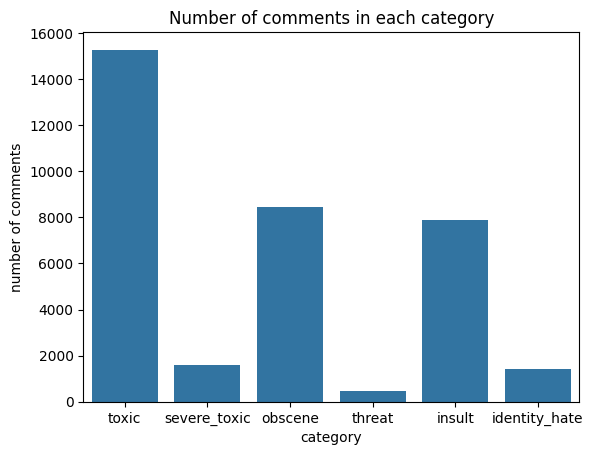

In [10]:
counts = []
for category in categories:
    counts.append((category, df[category].sum()))
df_stats = pd.DataFrame(counts, columns=['category', 'number of comments'])
df_stats
plt.figure()
sns.barplot(x='category', y='number of comments', data=df_stats)
plt.title("Number of comments in each category")
plt.show()

In [12]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [13]:
MAX_FEATURES = 200000
MAX_LEN = 300

In [14]:
tokenizer = Tokenizer(num_words=MAX_FEATURES, oov_token="<OOV>")
tokenizer.fit_on_texts(X)
sequences = tokenizer.texts_to_sequences(X)
padded_sequences = pad_sequences(sequences, maxlen=MAX_LEN, padding='post')

In [15]:
X_train, X_temp, y_train, y_temp = train_test_split(padded_sequences, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.33, random_state=42)

In [16]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(32).prefetch(tf.data.experimental.AUTOTUNE)

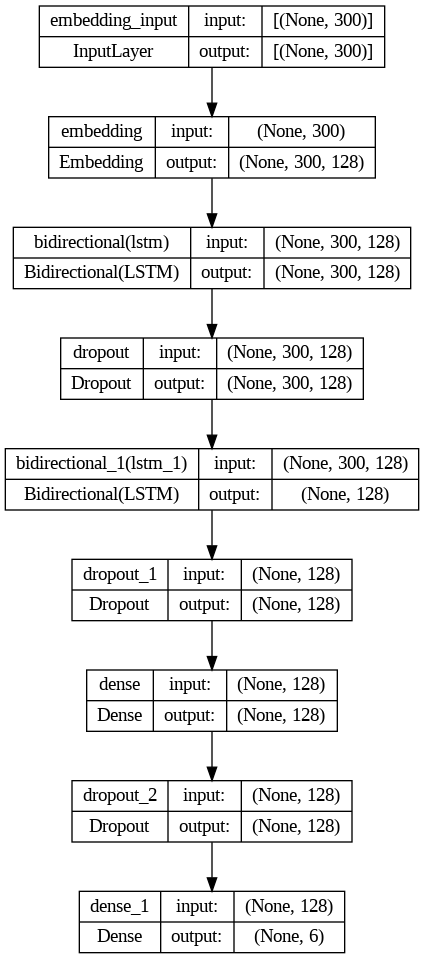

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(MAX_FEATURES, 128, input_length=MAX_LEN),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(6, activation='sigmoid')
])

# Plot the model
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=True)

In [18]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 300, 128)          25600000  
                                                                 
 bidirectional (Bidirection  (None, 300, 128)          98816     
 al)                                                             
                                                                 
 dropout (Dropout)           (None, 300, 128)          0         
                                                                 
 bidirectional_1 (Bidirecti  (None, 128)               98816     
 onal)                                                           
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 128)               1

In [20]:
history = model.fit(train_dataset, epochs=10, validation_data=val_dataset)

Epoch 1/10
3491/3491 [==============================] - 247s 68ms/step - loss: 0.0716 - accuracy: 0.9355 - val_loss: 0.0516 - val_accuracy: 0.9940
Epoch 2/10
3491/3491 [==============================] - 172s 49ms/step - loss: 0.0449 - accuracy: 0.9892 - val_loss: 0.0531 - val_accuracy: 0.9940
Epoch 3/10
3491/3491 [==============================] - 174s 50ms/step - loss: 0.0372 - accuracy: 0.9887 - val_loss: 0.0587 - val_accuracy: 0.9940
Epoch 4/10
3491/3491 [==============================] - 172s 49ms/step - loss: 0.0320 - accuracy: 0.9873 - val_loss: 0.0663 - val_accuracy: 0.9940
Epoch 5/10
3491/3491 [==============================] - 175s 50ms/step - loss: 0.0281 - accuracy: 0.9347 - val_loss: 0.0703 - val_accuracy: 0.9940
Epoch 6/10
3491/3491 [==============================] - 175s 50ms/step - loss: 0.0246 - accuracy: 0.9344 - val_loss: 0.0837 - val_accuracy: 0.9921
Epoch 7/10
3491/3491 [==============================] - 178s 51ms/step - loss: 0.0217 - accuracy: 0.8961 - val_loss: 0

<Figure size 800x500 with 0 Axes>

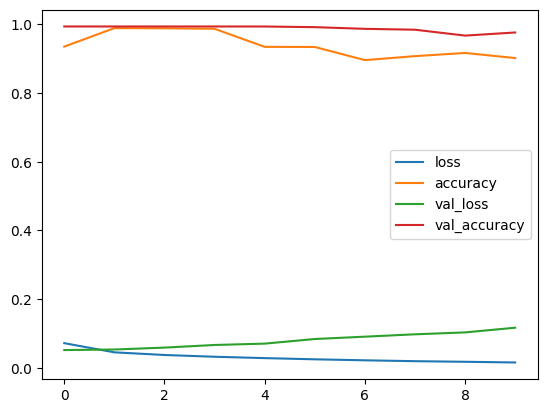

In [21]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()

In [22]:
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f'Test accuracy: {test_accuracy}')

494/494 [==============================] - 11s 23ms/step - loss: 0.1174 - accuracy: 0.9794
Test accuracy: 0.9794277548789978


In [23]:
def score_comment(comment):
    preprocessed_comment = preprocess_text(comment)
    sequence = tokenizer.texts_to_sequences([preprocessed_comment])
    padded_sequence = pad_sequences(sequence, maxlen=MAX_LEN, padding='post')
    prediction = model.predict(padded_sequence)
    return prediction


In [24]:
!pip install gradio
import gradio as gr

def score_comment_interface(comment):
    result = score_comment(comment)
    result_text = ""
    for idx, col in enumerate(df.columns[2:]):
        result_text += f"{col}: {'yes' if result[0][idx] > 0.5 else 'No'}\n"
    return result_text

interface = gr.Interface(fn=score_comment_interface, inputs=gr.Textbox(lines=2, placeholder='Comment to score'), outputs='text')
interface.launch(share=True)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 36.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.0/92.0 kB 13.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 35.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 145.0/145.0 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 90.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.4/62.4 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 20.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 10.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.6/53.6 kB 8.7 M